# Generating new faces with Variational Autoencoders


## GENERATIVE MODELS

In [1]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [2]:
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d jessicali9530/celeba-dataset

cp: cannot stat 'kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset
License(s): other
 98% 1.31G/1.33G [00:17<00:00, 246MB/s]
100% 1.33G/1.33G [00:17<00:00, 80.2MB/s]


In [3]:
import os
from glob import glob

WEIGHTS_FOLDER = './weights/'
DATA_FOLDER = './data/img_align_celeba/'

if not os.path.exists(WEIGHTS_FOLDER):
  os.makedirs(os.path.join(WEIGHTS_FOLDER,"AE"))
  os.makedirs(os.path.join(WEIGHTS_FOLDER,"VAE"))

#Unzip the dataset downloaded from kaggle
from zipfile import ZipFile
with ZipFile('celeba-dataset.zip', 'r') as zipObj:
   # Extract all the contents of zip file in the data directory
   zipObj.extractall('./data/')

Caution (for Colab users) : Do not attempt to explore the directory using the viewer on the left as the page becomes unresponsive owing to the large size of the dataset.

### Imports

In [4]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Import from tensorflow.keras
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from keras.models import Model
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import plot_model

###Data

In [5]:
filenames = np.array(glob(os.path.join(DATA_FOLDER, '*/*.jpg')))
NUM_IMAGES = len(filenames)
print("Total number of images : " + str(NUM_IMAGES))

Total number of images : 202599


In [6]:
INPUT_DIM = (128,128,3) # Image dimension
BATCH_SIZE = 512
Z_DIM = 200 # Dimension of the latent vector (z)

data_flow = ImageDataGenerator(rescale=1./255).flow_from_directory(DATA_FOLDER,
                                                                   target_size = INPUT_DIM[:2],
                                                                   batch_size = BATCH_SIZE,
                                                                   shuffle = True,
                                                                   class_mode = 'input',
                                                                   subset = 'training'
                                                                   )

Found 202599 images belonging to 1 classes.


### MODEL ARCHITECTURE


## VARIATIONAL AUTOENCODER



### CODE

#### Building the Encoder


In [14]:
# ipython-input-7-98e8a0b6bbd2
# ENCODER
def build_vae_encoder(input_dim, output_dim, conv_filters, conv_kernel_size,
                  conv_strides, use_batch_norm = False, use_dropout = False):

  # Clear tensorflow session to reset layer index numbers to 0 for LeakyRelu,
  # BatchNormalization and Dropout.
  # Otherwise, the names of above mentioned layers in the model
  # would be inconsistent
  global K
  K.clear_session()

  # Number of Conv layers
  n_layers = len(conv_filters)

  # Define model input
  encoder_input = Input(shape = input_dim, name = 'encoder_input')
  x = encoder_input

  # Add convolutional layers
  for i in range(n_layers):
      x = Conv2D(filters = conv_filters[i],
                  kernel_size = conv_kernel_size[i],
                  strides = conv_strides[i],
                  padding = 'same',
                  name = 'encoder_conv_' + str(i)
                  )(x)
      if use_batch_norm:
        x = BathcNormalization()(x)

      x = LeakyReLU()(x)

      if use_dropout:
        x = Dropout(rate=0.25)(x)

  # Required for reshaping latent vector while building Decoder
  shape_before_flattening = x.shape[1:]

  x = Flatten()(x)

  mean_mu = Dense(output_dim, name = 'mu')(x)
  log_var = Dense(output_dim, name = 'log_var')(x)

  # Defining a function for sampling
  def sampling(args):
    mean_mu, log_var = args
    epsilon = tf.random.normal(shape=tf.shape(mean_mu), mean=0., stddev=1.)
    # Use tf.math.exp instead of K.exp
    return mean_mu + tf.math.exp(log_var/2)*epsilon

  # Using a Keras Lambda Layer to include the sampling function as a layer
  # in the model
  encoder_output = Lambda(sampling, output_shape=(output_dim,), name='encoder_output')([mean_mu, log_var])
  return encoder_input, encoder_output, mean_mu, log_var, shape_before_flattening, Model(encoder_input, encoder_output)

In [15]:
vae_encoder_input, vae_encoder_output,  mean_mu, log_var, vae_shape_before_flattening, vae_encoder  = build_vae_encoder(input_dim = INPUT_DIM,
                                    output_dim = Z_DIM,
                                    conv_filters = [32, 64, 64, 64],
                                    conv_kernel_size = [3,3,3,3],
                                    conv_strides = [2,2,2,2])

vae_encoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_input             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_conv_0 (Conv2D)   │ (None, 64, 64, 32)     │            896 │ encoder_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu (LeakyReLU)   │ (None, 64, 64, 32)     │              0 │ encoder_conv_0[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_conv_1 (Conv2D)   │ (None, 32, 32, 64)     │         18,496 │ leaky_re_lu[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_1 (LeakyReLU) │ (None, 32, 32, 64)     │              0 │ encoder_conv_1[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_conv_2 (Conv2D)   │ (None, 16, 16, 64)     │         36,928 │ leaky_re_lu_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_2 (LeakyReLU) │ (None, 16, 16, 64)     │              0 │ encoder_conv_2[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_conv_3 (Conv2D)   │ (None, 8, 8, 64)       │         36,928 │ leaky_re_lu_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_3 (LeakyReLU) │ (None, 8, 8, 64)       │              0 │ encoder_conv_3[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 4096)           │              0 │ leaky_re_lu_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mu (Dense)                │ (None, 200)            │        819,400 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ log_var (Dense)           │ (None, 200)            │        819,400 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_output (Lambda)   │ (None, 200)            │              0 │ mu[0][0],              │
│                           │                        │                │ log_var[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,732,048 (6.61 MB)

 Trainable params: 1,732,048 (6.61 MB)

 Non-trainable params: 0 (0.00 B)

#### Building the Decoder
Since the Decoder remains the same, the Decoder architecture of the Simple Autoencoder is reused.

In [16]:
# Decoder
def build_decoder(input_dim, shape_before_flattening, conv_filters, conv_kernel_size,
                  conv_strides):

  # Number of Conv layers
  n_layers = len(conv_filters)

  # Define model input
  decoder_input = Input(shape = (input_dim,) , name = 'decoder_input')

  # To get an exact mirror image of the encoder
  x = Dense(np.prod(shape_before_flattening))(decoder_input)
  x = Reshape(shape_before_flattening)(x)

  # Add convolutional layers
  for i in range(n_layers):
      x = Conv2DTranspose(filters = conv_filters[i],
                  kernel_size = conv_kernel_size[i],
                  strides = conv_strides[i],
                  padding = 'same',
                  name = 'decoder_conv_' + str(i)
                  )(x)

      # Adding a sigmoid layer at the end to restrict the outputs
      # between 0 and 1
      if i < n_layers - 1:
        x = LeakyReLU()(x)
      else:
        x = Activation('sigmoid')(x)

  # Define model output
  decoder_output = x

  return decoder_input, decoder_output, Model(decoder_input, decoder_output)

In [18]:
vae_decoder_input, vae_decoder_output, vae_decoder = build_decoder(
    input_dim=Z_DIM,
    shape_before_flattening=vae_shape_before_flattening,  # Use the assigned variable returned by build_vae_encoder
    conv_filters=[64, 64, 32, 3],
    conv_kernel_size=[3, 3, 3, 3],
    conv_strides=[2, 2, 2, 2]
)

vae_decoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)           │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4096)                │         823,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_conv_0 (Conv2DTranspose)     │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_conv_1 (Conv2DTranspose)     │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_conv_2 (Conv2DTranspose)     │ (None, 64, 64, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_conv_3 (Conv2DTranspose)     │ (None, 128, 128, 3)         │             867 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 128, 128, 3)         │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 916,483 (3.50 MB)

 Trainable params: 916,483 (3.50 MB)

 Non-trainable params: 0 (0.00 B)

#### Attaching the Decoder to the Encoder


In [19]:
# The input to the model will be the image fed to the encoder.
vae_input = vae_encoder_input

# Output will be the output of the decoder. The term - decoder(encoder_output)
# combines the model by passing the encoder output to the input of the decoder.
vae_output = vae_decoder(vae_encoder_output)

# Input to the combined model will be the input to the encoder.
# Output of the combined model will be the output of the decoder.
vae_model = Model(vae_input, vae_output)

vae_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_input             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_conv_0 (Conv2D)   │ (None, 64, 64, 32)     │            896 │ encoder_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu (LeakyReLU)   │ (None, 64, 64, 32)     │              0 │ encoder_conv_0[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_conv_1 (Conv2D)   │ (None, 32, 32, 64)     │         18,496 │ leaky_re_lu[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_1 (LeakyReLU) │ (None, 32, 32, 64)     │              0 │ encoder_conv_1[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_conv_2 (Conv2D)   │ (None, 16, 16, 64)     │         36,928 │ leaky_re_lu_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_2 (LeakyReLU) │ (None, 16, 16, 64)     │              0 │ encoder_conv_2[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_conv_3 (Conv2D)   │ (None, 8, 8, 64)       │         36,928 │ leaky_re_lu_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_3 (LeakyReLU) │ (None, 8, 8, 64)       │              0 │ encoder_conv_3[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 4096)           │              0 │ leaky_re_lu_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mu (Dense)                │ (None, 200)            │        819,400 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ log_var (Dense)           │ (None, 200)            │        819,400 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_output (Lambda)   │ (None, 200)            │              0 │ mu[0][0],              │
│                           │                        │                │ log_var[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_1 (Functional) │ (None, 128, 128, 3)    │        916,483 │ encoder_output[0][0]   │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,648,531 (10.10 MB)

 Trainable params: 2,648,531 (10.10 MB)

 Non-trainable params: 0 (0.00 B)

### COMPILATION AND TRAINING


The loss function is a sum of RMSE and KL Divergence. A weight is assigned to the RMSE loss, known as the loss factor. The loss factor is multiplied with the RMSE loss. If we use a high loss factor, the drawbacks of a Simple Autoencoder start to appear. However, if we use a loss factor too low, the quality of the reconstructed images will be poor. Hence the loss factor is a hyperparameter that needs to be tuned.

In [20]:
LEARNING_RATE = 0.0005
N_EPOCHS = 15
LOSS_FACTOR = 10000

In [24]:
import tensorflow as tf
from keras.layers import Layer, Input, Lambda
# Import mse from tensorflow.keras.losses
from tensorflow.keras.losses import mse, binary_crossentropy

class KLLossLayer(Layer):
    def __init__(self, **kwargs):
        super(KLLossLayer, self).__init__(**kwargs)
    def call(self, inputs):
        mean_mu, log_var = inputs
        # Use tf.keras.backend instead of K
        kl_loss = -0.5 * tf.keras.backend.sum(1 + log_var - tf.keras.backend.square(mean_mu) - tf.keras.backend.exp(log_var), axis=-1)
        self.add_loss(tf.keras.backend.mean(kl_loss)) # Remove the inputs argument
        return inputs

# Define r_loss as Mean Squared Error
def r_loss(y_true, y_pred):
    """
    Calculates the reconstruction loss using Mean Squared Error (MSE).

    Args:
        y_true: The ground truth tensor.
        y_pred: The predicted tensor.

    Returns:
        The reconstruction loss.
    """
    return mse(y_true, y_pred)

def total_loss(y_true, y_pred):
    """
    Calculates the total loss, which is a combination of reconstruction loss and KL divergence loss.

    Args:
        y_true: The ground truth tensor.
        y_pred: The predicted tensor.

    Returns:
        The total loss.
    """
    # Calculate total loss - KL Divergence loss is calculated and added in the KLLossLayer
    return LOSS_FACTOR * r_loss(y_true, y_pred)

# Instantiate the KLLossLayer once and add it to the model
kl_loss_layer = KLLossLayer()
# Connect the kl_loss_layer to the mean and log variance tensors
kl_loss_layer([mean_mu, log_var])

# Assuming 'kl_loss' is intended to monitor KL Divergence,
#  define a function to calculate and return it:
def kl_loss(mean_mu, log_var):
    """
    Calculates the KL divergence loss.

    Args:
        mean_mu: The mean tensor.
        log_var: The log variance tensor.

    Returns:
        The KL divergence loss.
    """
    kl_loss = -0.5 * tf.keras.backend.sum(1 + log_var - tf.keras.backend.square(mean_mu) - tf.keras.backend.exp(log_var), axis=-1)
    return tf.keras.backend.mean(kl_loss)

In [25]:
adam_optimizer = Adam(learning_rate = LEARNING_RATE)

vae_model.compile(optimizer=adam_optimizer, loss = total_loss, metrics = [r_loss, kl_loss])

checkpoint_vae = ModelCheckpoint(os.path.join(WEIGHTS_FOLDER, 'VAE/weights.weights.h5'), save_weights_only = True, verbose=1)

In [26]:
vae_model.fit(data_flow,
              shuffle=True,
              epochs = N_EPOCHS,
              initial_epoch = 0,
              steps_per_epoch=int(NUM_IMAGES / BATCH_SIZE), # Convert to integer using int()
              callbacks=[checkpoint_vae])

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 710ms/step - kl_loss: 0.6553 - loss: 440.0640 - r_loss: 0.0440
Epoch 1: saving model to ./weights/VAE/weights.weights.h5
395/395 ━━━━━━━━━━━━━━━━━━━━ 301s 711ms/step - kl_loss: 0.6553 - loss: 439.6057 - r_loss: 0.0440
Epoch 2/15
  1/395 ━━━━━━━━━━━━━━━━━━━━ 1:19 203ms/step - kl_loss: 0.6855 - loss: 126.1798 - r_loss: 0.0126
Epoch 2: saving model to ./weights/VAE/weights.weights.h5


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step - kl_loss: 0.6855 - loss: 126.1798 - r_loss: 0.0126  
Epoch 3/15
395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 666ms/step - kl_loss: 0.6845 - loss: 119.5375 - r_loss: 0.0120
Epoch 3: saving model to ./weights/VAE/weights.weights.h5
395/395 ━━━━━━━━━━━━━━━━━━━━ 291s 667ms/step - kl_loss: 0.6845 - loss: 119.5179 - r_loss: 0.0120
Epoch 4/15
  1/395 ━━━━━━━━━━━━━━━━━━━━ 1:12 185ms/step - kl_loss: 0.6878 - loss: 102.4602 - r_loss: 0.0102
Epoch 4: saving model to ./weights/VAE/weights.weights.h5
395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step - kl_loss: 0.6878 - loss: 102.4602 - r_loss: 0.0102  
Epoch 5/15
395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 653ms/step - kl_loss: 0.6888 - loss: 95.9551 - r_loss: 0.0096
Epoch 5: saving model to ./weights/VAE/weights.weights.h5
395/395 ━━━━━━━━━━━━━━━━━━━━ 262s 653ms/step - kl_loss: 0.6888 - loss: 95.9474 - r_loss: 0.0096
Epoch 6/15
  1/395 ━━━━━━━━━━━━━━━━━━━━ 1:13 186ms/step - kl_loss: 0.6713 - loss: 86.1349 - r_loss: 0.0086
Epoch 6: savi

### RECONSTRUCTION.
The reconstruction process is the same as that of the Simple Autoencoder.

In [27]:
example_batch = next(data_flow)
example_batch = example_batch[0]
example_images = example_batch[:10]

In [32]:
import matplotlib.pyplot as plt

def plot_compare_vae(images=None):

  if images is None:
    example_batch = next(data_flow)
    example_batch = example_batch[0]
    images = example_batch[:10]

  n_to_show = images.shape[0]
  reconst_images = vae_model.predict(images)

  fig = plt.figure(figsize=(15, 3)) # plt is now defined
  fig.subplots_adjust(hspace=0.4, wspace=0.4)

  for i in range(n_to_show):
      img = images[i].squeeze()
      sub = fig.add_subplot(2, n_to_show, i+1)
      sub.axis('off')
      sub.imshow(img)

  for i in range(n_to_show):
      img = reconst_images[i].squeeze()
      sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
      sub.axis('off')
      sub.imshow(img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


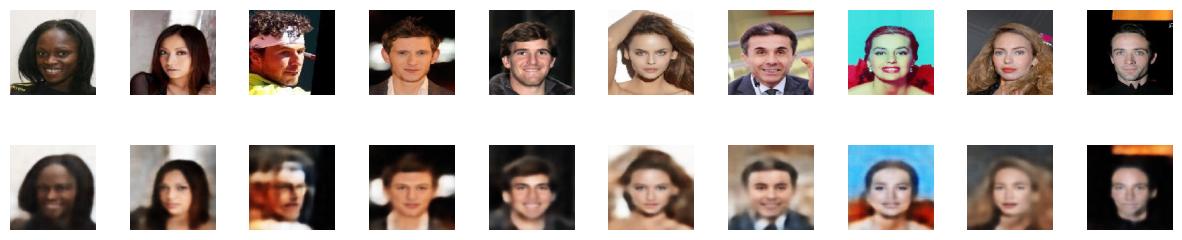

In [33]:
plot_compare_vae(images = example_images)

It is observed that the first 50 elements of the Z dimensional vector are very similar to a standard normal distribution. The addition of the KL divergence term is therefore, justified.